# Plot Chemical Shieldings

This notebook contains a workflow that:
- Reads chemical shielding results from a csv file
- Removes zero values from the end of it (sometimes occurred depending on batch size with the bespoke shielding models)
- Plots the ensemble chemical shieldings for a given trajectory
- Converts chemical shieldings to chemical shifts, along with sampling and ML errors
   - To note: Sampling error here is not computed using the autocorrelation time
   - Also to note: ML error is only computed for bespoke models, which comes from the committee of models
- Plots the chemical shifts across different types of trajectories, e.g.:
   - Bespoke MD potential + Bespoke chemical shielding model
   - Bespoke MD potential + General-purpose shielding model
   - General-purpose MD potential + Bespoke shielding model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ase
import ase.io
from scipy.stats import sem, gaussian_kde
%matplotlib inline

In [2]:
def remove_zeros(df):
    ## Remove rows with ANY zero values from the pandas dataframe. This might dtop some rows containing non-zero values too.
    df_no_zeros = df[(df != 0).all(1)]
    rows_dropped = len(df)-len(df_no_zeros)
    print("")
    print(str(rows_dropped)+ " rows with zero values dropped.")
    print("")
    print("PLEASE NOTE:")
    print("Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.")
    print("However, if you still have enough frames for converged statistical sampling it shouldn't matter.")
    return df_no_zeros

In [3]:
data = pd.read_csv('../besmd_besshield/PI_NVT/benzene_II/shieldings.csv', index_col=0)
data
#data.drop(data.columns[:4], axis=1, inplace=True)
#print(np.mean(data.mean()[0:48][16:24]))
#print(data.mean()[0:48])

,C1,C2,C3,C4,C5,C6,C7,C8,H1,H2,...,H19err,H20err,C21err,C22err,C23err,C24err,H21err,H22err,H23err,H24err
0,44.564487,34.502261,51.401831,49.822463,28.873397,41.940046,26.689562,37.107912,24.128584,24.904207,...,0.086639,0.086623,1.575397,0.792404,0.780790,1.838844,0.151956,0.203541,0.134389,0.136116
1,36.888188,30.598138,38.925756,48.453052,46.406192,49.995398,45.397662,48.702756,24.046943,24.458441,...,0.136357,0.133415,0.818990,1.048041,0.662472,1.341592,0.179028,0.163723,0.148769,0.167122
2,44.261909,48.266204,23.076401,31.341891,46.773137,44.240473,52.981611,34.776660,24.452535,25.877508,...,0.117863,0.154166,1.671131,0.695123,1.207513,0.798960,0.186141,0.155797,0.134417,0.150191
3,29.595076,36.296915,46.454256,40.492254,39.901661,36.632569,17.209057,30.444811,25.169522,24.585886,...,0.069967,0.164561,1.016856,1.447575,0.919003,0.687427,0.113985,0.198607,0.116771,0.163589
4,43.451813,37.804181,37.077369,28.077136,30.155421,38.894507,20.203654,53.759457,24.535008,25.898594,...,0.082947,0.168075,0.636319,1.135427,0.719836,1.090261,0.191354,0.210223,0.089937,0.211286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,46.676149,36.795460,47.751146,53.360563,37.038007,33.498488,39.939488,33.760378,26.827281,25.190607,...,0.130230,0.143913,1.131270,0.713023,1.018978,0.855140,0.132659,0.193489,0.145885,0.155929
7597,31.364238,36.629625,31.238126,31.576340,37.675758,42.225628,47.879799,38.194477,24.674129,25.569871,...,0.173980,0.145860,1.051412,1.138852,0.514334,1.109721,0.100227,0.151278,0.131851,0.154640
7598,41.643132,37.766679,43.258766,27.279904,44.456438,49.463095,40.630805,37.635697,25.711950,23.508450,...,0.162408,0.146473,0.582647,1.102297,0.838157,1.548842,0.106375,0.154760,0.130140,0.250971
7599,39.951832,44.958275,30.759110,43.917927,39.746914,37.751792,28.184145,42.771462,24.641340,26.727751,...,0.142853,0.099239,0.691973,1.221869,0.982069,1.405482,0.122849,0.211556,0.121324,0.161986


## Notes

For benzene_I, the equivalent carbons and hydrogens are as follows: 
- C1-C4 (C1 in paper)
- C9-C12 (C2 in paper)
- C5-C8 (C3 in paper)
- H5-H8 (H1 in paper)
- H1-H4 (H2 in paper)
- H9-H12 (H3 in paper)

For benzene_II, after looking at VMD, the equivalent carbons and hydrogens are as follows (along with the corresponding carbon as labelled in the paper): -- Remember this is technically benzene I
- C17-C24 (C1 in paper)
- C9-C16 (C2 in paper)
- C1-C8 (C3 in paper)
- H1-H8 (H1 in paper) 
- H17-H24 (H2 in paper) 
- H9-H16 (H3 in paper)

For succinic_alpha, equivalent carbons and hydrogens are as follows:
- C3, C4, C7, C8 (C1 in paper) (methyl C) --INCORRECTLY LABELLED AS CARBOXYL C IN PAPER
- C1, C2, C5, C6 (C2 in paper) (carboxyl C) --INCORRECTLY LABELLED AS METHYL C IN PAPER
- H5, H6, H11, H12 (H1 in paper) (methyl H)
- H3, H4, H9, H10 (H2 in paper) (methyl H)
- H1, H2, H7, H8 (H3 in paper) (carboxyl H)

For succinic_beta, equivalent carbons and hydrogens are as follows:
- C1-C4 (C1 in paper) (methyl C) --INCORRECTLY LABELLED AS CARBOXYL C IN PAPER
- C5-C8 (C2 in paper) (carboxyl C) --INCORRECTLY LABELLED AS METHYL C IN PAPER
- H1-H4 (H1 in paper) (methyl H)
- H5-H8 (H2 in paper) (methyl H)
- H9-H12 (H3 in paper) (carboxyl H)

For glycine_alpha, equivalent carbons and hydrogens are as follows:
-  C1-C4 (C1 in paper) (carboxyl C)
-  C5-C8 (C2 in paper) (methyl C)
-  H1-H4 (H1 in paper) (methyl H)
-  H5-H8 (H2 in paper) (methyl H)
-  H9-H20 (H3 in paper) (ammonium H)
-  N1-N4 (N1 in paper) (ammonium N)

For glycine_beta, equivalent carbons and hydrogens are as follows:
-  C1-C2 (C1 in paper) (carboxyl C)
-  C3-C4 (C2 in paper) (methyl C)
-  H1-H2 (H1 in paper) (methyl H)
-  H3-H4 (H2 in paper) (methyl H)
-  H5-H10 (H3 in paper) (ammonium H)
-  N1-N2 (N1 in paper) (ammonium N)

For glycine_gamma, equivalent carbons and hydrogens are as follows:
- C1-C3 (C1 in paper) (carboxyl C)
- C4-C6 (C2 in paper) (methyl C)
- H1-H3 (H1 in paper) (methyl H)
- H4-H6 (H2 in paper) (methyl H)
- H7-H15 (H3 in paper) (ammonium H)
- N1-N3 (N1 in paper) (ammonium N)

In [4]:
# New process functions
def process_glycine_alpha(raw_data): 
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C1', 'C2', 'C3', 'C4']:
        C1.extend(df[x])
    C2 = []
    for x in ['C5', 'C6', 'C7', 'C8']:
        C2.extend(df[x])
    
    N1 = []
    for x in ['N1', 'N2', 'N3', 'N4']:
        N1.extend(df[x])
    
    H1 = []
    for x in ['H1', 'H2', 'H3', 'H4']:
        H1.extend(df[x])
    H2 = []
    for x in ['H5', 'H6', 'H7', 'H8']:
        H2.extend(df[x])
    H3_a = []
    for x in ['H9', 'H10', 'H11', 'H12']:
        H3_a.extend(df[x])
    H3_b = []
    for x in ['H13', 'H14', 'H15', 'H16']:
        H3_b.extend(df[x])
    H3_c = []
    for x in ['H17', 'H18', 'H19', 'H20']:
        H3_c.extend(df[x])
    
    if len(df.columns)>45:    
        C1err = []
        for x in ['C1err', 'C2err', 'C3err', 'C4err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C5err', 'C6err', 'C7err', 'C8err']:
            C2err.extend(df[x])

        N1err = []
        for x in ['N1err', 'N2err', 'N3err', 'N4err']:
            N1err.extend(df[x])

        H1err = []
        for x in ['H1err', 'H2err', 'H3err', 'H4err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H5err', 'H6err', 'H7err', 'H8err']:
            H2err.extend(df[x])
        H3_aerr = []
        for x in ['H9err', 'H10err', 'H11err', 'H12err']:
            H3_aerr.extend(df[x])
        H3_berr = []
        for x in ['H13err', 'H14err', 'H15err', 'H16err']:
            H3_berr.extend(df[x])
        H3_cerr = []
        for x in ['H17err', 'H18err', 'H19err', 'H20err']:
            H3_cerr.extend(df[x])
    
    zeros=0
    if len(df.columns)>45:
        for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c, C1err, C2err, N1err, H1err, H2err, H3_aerr, H3_berr, H3_cerr]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
        print("")
    
    print("For glycine, ammonium H nuclei have been split into three. These sets actually have distinct calculated shieldings")
    print("Furthermore, the dataframe could not be created with arrays of different lengths.")
    print("However, please combine these three shieldings into one before further processing, as was done in the paper, because rotation around the C-N bond is faster than the NMR acquisition timescale.")
    
    if len(df.columns)>45:
        processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c, 'C1err':C1err, 'C2err':C2err, 'N1err':N1err, 'H1err':H1err, 'H2err': H2err, 'H3_aerr':H3_aerr, 'H3_berr':H3_berr, 'H3_cerr':H3_cerr}
    else:
        processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

def process_glycine_beta(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C1', 'C2']:
        C1.extend(df[x])
    C2 = []
    for x in ['C3', 'C4']:
        C2.extend(df[x])
    
    N1 = []
    for x in ['N1', 'N2']:
        N1.extend(df[x])
    
    H1 = []
    for x in ['H1', 'H2']:
        H1.extend(df[x])
    H2 = []
    for x in ['H3', 'H4']:
        H2.extend(df[x])
    H3_a = []
    for x in ['H5', 'H6']:
        H3_a.extend(df[x])
    H3_b = []
    for x in ['H7', 'H8']:
        H3_b.extend(df[x])
    H3_c = []
    for x in ['H9', 'H10']:
        H3_c.extend(df[x])
    
    if len(df.columns)>20:    
        C1err = []
        for x in ['C1err', 'C2err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C3err', 'C4err']:
            C2err.extend(df[x])

        N1err = []
        for x in ['N1err', 'N2err']:
            N1err.extend(df[x])

        H1err = []
        for x in ['H1err', 'H2err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H3err', 'H4err']:
            H2err.extend(df[x])
        H3_aerr = []
        for x in ['H5err', 'H6err']:
            H3_aerr.extend(df[x])
        H3_berr = []
        for x in ['H7err', 'H8err']:
            H3_berr.extend(df[x])
        H3_cerr = []
        for x in ['H9err', 'H10err']:
            H3_cerr.extend(df[x])
    
    zeros=0
    if len(df.columns)>20:
        for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c, C1err, C2err, N1err, H1err, H2err, H3_aerr, H3_berr, H3_cerr]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
        print("")
    
    print("For glycine, ammonium H nuclei have been split into three. These sets actually have distinct calculated shieldings")
    print("Furthermore, the dataframe could not be created with arrays of different lengths.")
    print("However, please combine these three shieldings into one before further processing, as was done in the paper, because rotation around the C-N bond is faster than the NMR acquisition timescale.")
    
    if len(df.columns)>20:
        processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c, 'C1err':C1err, 'C2err':C2err, 'N1err':N1err, 'H1err':H1err, 'H2err': H2err, 'H3_aerr':H3_aerr, 'H3_berr':H3_berr, 'H3_cerr':H3_cerr}
    else:
        processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

def process_glycine_gamma(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C1', 'C2', 'C3']:
        C1.extend(df[x])
    C2 = []
    for x in ['C4', 'C5', 'C6']:
        C2.extend(df[x])
    
    N1 = []
    for x in ['N1', 'N2', 'N3']:
        N1.extend(df[x])
    
    H1 = []
    for x in ['H1', 'H2', 'H3']:
        H1.extend(df[x])
    H2 = []
    for x in ['H4', 'H5', 'H6']:
        H2.extend(df[x])
    H3_a = []
    for x in ['H7', 'H8', 'H9']:
        H3_a.extend(df[x])
    H3_b = []
    for x in ['H10', 'H11', 'H12']:
        H3_b.extend(df[x])
    H3_c = []
    for x in ['H13', 'H14', 'H15']:
        H3_c.extend(df[x])
    
    if len(df.columns)>35:    
        C1err = []
        for x in ['C1err', 'C2err', 'C3err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C4err', 'C5err', 'C6err']:
            C2err.extend(df[x])

        N1err = []
        for x in ['N1err', 'N2err', 'N3err']:
            N1err.extend(df[x])

        H1err = []
        for x in ['H1err', 'H2err', 'H3err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H4err', 'H5err', 'H6err']:
            H2err.extend(df[x])
        H3_aerr = []
        for x in ['H7err', 'H8err', 'H9err']:
            H3_aerr.extend(df[x])
        H3_berr = []
        for x in ['H10err', 'H11err', 'H12err']:
            H3_berr.extend(df[x])
        H3_cerr = []
        for x in ['H13err', 'H14err', 'H15err']:
            H3_cerr.extend(df[x])
    
    zeros=0
    if len(df.columns)>35:
        for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c, C1err, C2err, N1err, H1err, H2err, H3_aerr, H3_berr, H3_cerr]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
        print("")
    
    print("For glycine, ammonium H nuclei have been split into three. These sets actually have distinct calculated shieldings")
    print("Furthermore, the dataframe could not be created with arrays of different lengths.")
    print("However, please combine these three shieldings into one before further processing, as was done in the paper, because rotation around the C-N bond is faster than the NMR acquisition timescale.")
    
    if len(df.columns)>35:
        processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c, 'C1err':C1err, 'C2err':C2err, 'N1err':N1err, 'H1err':H1err, 'H2err': H2err, 'H3_aerr':H3_aerr, 'H3_berr':H3_berr, 'H3_cerr':H3_cerr}
    else:
        processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

def process_succinic_alpha(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C3', 'C4', 'C7', 'C8']:
        C1.extend(df[x])
    C2 = []
    for x in ['C1', 'C2', 'C5', 'C6']:
        C2.extend(df[x])
    
    H1 = []
    for x in ['H5', 'H6', 'H11', 'H12']:
        H1.extend(df[x])
    H2 = []
    for x in ['H3', 'H4', 'H9', 'H10']:
        H2.extend(df[x])
    H3 = []
    for x in ['H1', 'H2', 'H7', 'H8']:
        H3.extend(df[x])
    
    if len(df.columns)>30:
        C1err = []
        for x in ['C3err', 'C4err', 'C7err', 'C8err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C1err', 'C2err', 'C5err', 'C6err']:
            C2err.extend(df[x])

        H1err = []
        for x in ['H5err', 'H6err', 'H11err', 'H12err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H3err', 'H4err', 'H9err', 'H10err']:
            H2err.extend(df[x])
        H3err = []
        for x in ['H1err', 'H2err', 'H7err', 'H8err']:
            H3err.extend(df[x])
    
    zeros=0
    if len(df.columns)>30:
        for x in [C1, C2, H1, H2, H3, C1err, C2err, H1err, H2err, H3err]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, H1, H2, H3]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
    
    if len(df.columns)>30:
        processed = {'C1':C1, 'C2':C2, 'H1':H1, 'H2': H2, 'H3':H3, 'C1err':C1err, 'C2err':C2err, 'H1err':H1err, 'H2err': H2err, 'H3err':H3err}
    else:
        processed = {'C1':C1, 'C2':C2, 'H1':H1, 'H2': H2, 'H3':H3}
        
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

def process_succinic_beta(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C1', 'C2', 'C3', 'C4']:
        C1.extend(df[x])
    C2 = []
    for x in ['C5', 'C6', 'C7', 'C8']:
        C2.extend(df[x])
    
    H1 = []
    for x in ['H1', 'H2', 'H3', 'H4']:
        H1.extend(df[x])
    H2 = []
    for x in ['H5', 'H6', 'H7', 'H8']:
        H2.extend(df[x])
    H3 = []
    for x in ['H9', 'H10', 'H11', 'H12']:
        H3.extend(df[x])
    
    if len(df.columns)>30:
        C1err = []
        for x in ['C1err', 'C2err', 'C3err', 'C4err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C5err', 'C6err', 'C7err', 'C8err']:
            C2err.extend(df[x])

        H1err = []
        for x in ['H1err', 'H2err', 'H3err', 'H4err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H5err', 'H6err', 'H7err', 'H8err']:
            H2err.extend(df[x])
        H3err = []
        for x in ['H9err', 'H10err', 'H11err', 'H12err']:
            H3err.extend(df[x])
    
    zeros=0
    if len(df.columns)>30:
        for x in [C1, C2, H1, H2, H3, C1err, C2err, H1err, H2err, H3err]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, H1, H2, H3]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
    
    
    if len(df.columns)>30:
        processed = {'C1':C1, 'C2':C2, 'H1':H1, 'H2': H2, 'H3':H3, 'C1err':C1err, 'C2err':C2err, 'H1err':H1err, 'H2err': H2err, 'H3err':H3err}
    else:
        processed = {'C1':C1, 'C2':C2, 'H1':H1, 'H2': H2, 'H3':H3}
    
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df


def process_benzene_I(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C1', 'C2', 'C3', 'C4']:
        C1.extend(df[x])
    C2 = []
    for x in ['C9', 'C10', 'C11', 'C12']:
        C2.extend(df[x])
    C3 = []
    for x in ['C5', 'C6', 'C7', 'C8']:
        C3.extend(df[x])
    
    H1 = []
    for x in ['H5', 'H6', 'H7', 'H8']:
        H1.extend(df[x])
    H2 = []
    for x in ['H1', 'H2', 'H3', 'H4']:
        H2.extend(df[x])
    H3 = []
    for x in ['H9', 'H10', 'H11', 'H12']:
        H3.extend(df[x])
    
    if len(df.columns)>30:
        C1err = []
        for x in ['C1err', 'C2err', 'C3err', 'C4err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C9err', 'C10err', 'C11err', 'C12err']:
            C2err.extend(df[x])
        C3err = []
        for x in ['C5err', 'C6err', 'C7err', 'C8err']:
            C3err.extend(df[x])
        H1err = []
        for x in ['H5err', 'H6err', 'H7err', 'H8err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H1err', 'H2err', 'H3err', 'H4err']:
            H2err.extend(df[x])
        H3err = []
        for x in ['H9err', 'H10err', 'H11err', 'H12err']:
            H3err.extend(df[x])
    
    zeros=0
    if len(df.columns)>30:
        for x in [C1, C2, C3, H1, H2, H3, C1err, C2err, C3err, H1err, H2err, H3err]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, C3, H1, H2, H3]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
    
    
    if len(df.columns)>30:
        processed = {'C1':C1, 'C2':C2, 'C3':C3, 'H1':H1, 'H2': H2, 'H3':H3, 'C1err':C1err, 'C2err':C2err, 'C3err':C3err, 'H1err':H1err, 'H2err': H2err, 'H3err':H3err}
    else:
        processed = {'C1':C1, 'C2':C2, 'C3':C3, 'H1':H1, 'H2': H2, 'H3':H3}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df


def process_benzene_II(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24']:
        C1.extend(df[x])
    
    C2 = []
    for x in ['C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']:
        C2.extend(df[x])
    C3 = []
    for x in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']:
        C3.extend(df[x])
    
    H1 = []
    for x in ['H1', 'H2', 'H3', 'H4','H5', 'H6', 'H7', 'H8']:
        H1.extend(df[x])
    H2 = []
    for x in ['H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']:
        H2.extend(df[x])
    H3 = []
    for x in ['H9', 'H10', 'H11', 'H12','H13', 'H14', 'H15', 'H16']:
        H3.extend(df[x])
    
    if len(df.columns)>60:
        C1err = []
        for x in ['C17err', 'C18err', 'C19err', 'C20err', 'C21err', 'C22err', 'C23err', 'C24err']:
            C1err.extend(df[x])
        C2err = []
        for x in ['C9err', 'C10err', 'C11err', 'C12err', 'C13err', 'C14err', 'C15err', 'C16err']:
            C2err.extend(df[x])
        C3err = []
        for x in ['C1err', 'C2err', 'C3err', 'C4err', 'C5err', 'C6err', 'C7err', 'C8err']:
            C3err.extend(df[x])
        H1err = []
        for x in ['H1err', 'H2err', 'H3err', 'H4err', 'H5err', 'H6err', 'H7err', 'H8err']:
            H1err.extend(df[x])
        H2err = []
        for x in ['H17err', 'H18err', 'H19err', 'H20err', 'H21err', 'H22err', 'H23err', 'H24err']:
            H2err.extend(df[x])
        H3err = []
        for x in ['H9err', 'H10err', 'H11err', 'H12err', 'H13err', 'H14err', 'H15err', 'H16err']:
            H3err.extend(df[x])
    
    zeros=0
    if len(df.columns)>60:
        for x in [C1, C2, C3, H1, H2, H3, C1err, C2err, C3err, H1err, H2err, H3err]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    else:
        for x in [C1, C2, C3, H1, H2, H3]:
            for i in range(len(x)):
                if x[i]==0:
                    zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
    
    
    if len(df.columns)>60:
        processed = {'C1':C1, 'C2':C2, 'C3':C3, 'H1':H1, 'H2': H2, 'H3':H3, 'C1err':C1err, 'C2err':C2err, 'C3err':C3err, 'H1err':H1err, 'H2err': H2err, 'H3err':H3err}
    else:
        processed = {'C1':C1, 'C2':C2, 'C3':C3, 'H1':H1, 'H2': H2, 'H3':H3}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df


In [5]:
ben_I_mbd=remove_zeros(process_benzene_I('../besmd_besshield/PI_NVT/benzene_I/shieldings.csv'))
ben_II_mbd=remove_zeros(process_benzene_II('../besmd_besshield/PI_NVT/benzene_II/shieldings.csv'))
suc_a_mbd=remove_zeros(process_succinic_alpha('../besmd_besshield/PI_NVT/succinic_alpha/shieldings.csv'))
suc_b_mbd=remove_zeros(process_succinic_beta('../besmd_besshield/PI_NVT/succinic_beta/shieldings.csv'))
gly_a_mbd=remove_zeros(process_glycine_alpha('../besmd_besshield/PI_NVT/glycine_alpha/shieldings.csv'))
gly_b_mbd=remove_zeros(process_glycine_beta('../besmd_besshield/PI_NVT/glycine_beta/shieldings.csv'))
gly_g_mbd=remove_zeros(process_glycine_gamma('../besmd_besshield/PI_NVT/glycine_gamma/shieldings.csv'))
ben_I_ts=remove_zeros(process_benzene_I('../besmd_besshield/PI_NVT_PBE-TS/benzene_I/shieldings.csv'))
ben_II_ts=remove_zeros(process_benzene_II('../besmd_besshield/PI_NVT_PBE-TS/benzene_II/shieldings.csv'))
suc_a_ts=remove_zeros(process_succinic_alpha('../besmd_besshield/PI_NVT_PBE-TS/succinic_alpha/shieldings.csv'))
suc_b_ts=remove_zeros(process_succinic_beta('../besmd_besshield/PI_NVT_PBE-TS/succinic_beta/shieldings.csv'))
gly_a_ts=remove_zeros(process_glycine_alpha('../besmd_besshield/PI_NVT_PBE-TS/glycine_alpha/shieldings.csv'))
gly_b_ts=remove_zeros(process_glycine_beta('../besmd_besshield/PI_NVT_PBE-TS/glycine_beta/shieldings.csv'))
gly_g_ts=remove_zeros(process_glycine_gamma('../besmd_besshield/PI_NVT_PBE-TS/glycine_gamma/shieldings.csv'))
ben_I_gen=remove_zeros(process_benzene_I('../genmd_besshield/PI_NVT/benzene_I/shieldings.csv'))
ben_II_gen=remove_zeros(process_benzene_II('../genmd_besshield/PI_NVT/benzene_II/shieldings.csv'))
suc_a_gen=remove_zeros(process_succinic_alpha('../genmd_besshield/PI_NVT/succinic_alpha/shieldings.csv'))
suc_b_gen=remove_zeros(process_succinic_beta('../genmd_besshield/PI_NVT/succinic_beta/shieldings.csv'))
gly_a_gen=remove_zeros(process_glycine_alpha('../genmd_besshield/PI_NVT/glycine_alpha/shieldings.csv'))
gly_b_gen=remove_zeros(process_glycine_beta('../genmd_besshield/PI_NVT/glycine_beta/shieldings.csv'))
gly_g_gen=remove_zeros(process_glycine_gamma('../genmd_besshield/PI_NVT/glycine_gamma/shieldings.csv'))
ben_I_gen_mbd=remove_zeros(process_benzene_I('../genmd_besshield/PI_NVT_PBE0/benzene_I/shieldings.csv'))
ben_II_gen_mbd=remove_zeros(process_benzene_II('../genmd_besshield/PI_NVT_PBE0/benzene_II/shieldings.csv'))
suc_a_gen_mbd=remove_zeros(process_succinic_alpha('../genmd_besshield/PI_NVT_PBE0/succinic_alpha/shieldings.csv'))
suc_b_gen_mbd=remove_zeros(process_succinic_beta('../genmd_besshield/PI_NVT_PBE0/succinic_beta/shieldings.csv'))
gly_a_gen_mbd=remove_zeros(process_glycine_alpha('../genmd_besshield/PI_NVT_PBE0/glycine_alpha/shieldings.csv'))
gly_b_gen_mbd=remove_zeros(process_glycine_beta('../genmd_besshield/PI_NVT_PBE0/glycine_beta/shieldings.csv'))
gly_g_gen_mbd=remove_zeros(process_glycine_gamma('../genmd_besshield/PI_NVT_PBE0/glycine_gamma/shieldings.csv'))

768 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.

64 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.

0 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.
8080 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.p

768 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.

64 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.

0 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.
384 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.py

In [6]:
def plot_shieldings(df, title):
    #plot density distribution of shieldings from a dataframe (dataframe must have shielding columns without error columns)
    if 'N1' in df.columns:
        rows=3
        fig, ax = plt.subplots(nrows=rows, figsize=(9,9), dpi=180)
    else:
        rows=2
        fig, ax = plt.subplots(nrows=rows, figsize=(9,6), dpi=180)
    colours=['blue', 'green','red', 'black', 'orange', 'purple', 'brown']
    lc = 0; lh = 0; ln = 0
    
    maxes_c=[];maxes_h=[];maxes_n=[]
    
    ax[0].set(title= 'Carbon', xlabel= r'Chemical Shielding, $\sigma$', ylabel='Gaussian KDE')
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
            ax[0].get_xticklabels() + ax[0].get_yticklabels()):
            item.set_fontsize(12)
    
    ax[1].set(title= 'Hydrogen', xlabel= r'Chemical Shielding, $\sigma$', ylabel='Gaussian KDE')
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
            ax[1].get_xticklabels() + ax[1].get_yticklabels()):
            item.set_fontsize(12)
    
    if 'N1' in df.columns:
        ax[2].set(title= 'Nitrogen', xlabel= r'Chemical Shielding, $\sigma$', ylabel='Gaussian KDE')
        for item in ([ax[2].title, ax[2].xaxis.label, ax[2].yaxis.label] +
                ax[2].get_xticklabels() + ax[2].get_yticklabels()):
                item.set_fontsize(12)
    
    for i in df.columns:
        #get appropriate x-values
        xs= np.linspace(df.min()[i],df.max()[i],200)
        
        #estimate density from relevant chemical shielding array in dataframe
        normalize = gaussian_kde(df[i])
        normalize.covariance_factor = lambda : .25
        normalize._compute_covariance()
        
        #plot shieldings
        if i[0]=='C' and len(i)<5:
            ax[0].plot(xs, normalize(xs), color=colours[lc], label=str(i))
            maxes_c.append(max(normalize(xs)))
            lc += 1
            ax[0].legend(loc=1, prop={'size': 8.5})
            
        if i[0]=='H'and len(i)<5:
            ax[1].plot(xs, normalize(xs), color=colours[lh], label=str(i))
            maxes_h.append(max(normalize(xs)))
            lh += 1
            ax[1].legend(loc=1, prop={'size': 8.5})
        if i[0]=='N'and len(i)<5:
            ax[2].plot(xs, normalize(xs), color=colours[ln], label=str(i))
            maxes_n.append(max(normalize(xs)))
            ln += 1
            ax[2].legend(loc=1, prop={'size': 8.5})
    
    lc = 0; lh = 0; ln = 0
    
    for i in df.columns:
        if i[0]=='C' and len(i)<5:
            ax[0].vlines(np.mean(df[i]), ymin= 0, ymax=(max(maxes_c)+(0.10*max(maxes_c))), linestyles="dashed", color=colours[lc])
            lc += 1
        if i[0]=='H'and len(i)<5:
            ax[1].vlines(np.mean(df[i]), ymin= 0, ymax=(max(maxes_h)+(0.10*max(maxes_h))), linestyles="dashed", color=colours[lh])
            lh += 1
        if i[0]=='N'and len(i)<5:
            ax[2].vlines(np.mean(df[i]), ymin= 0, ymax=(max(maxes_n)+(0.10*max(maxes_n))), linestyles="dashed", color=colours[ln])
            ln += 1
    
    fig.suptitle(title, size=16)
    #fig.delaxes(ax[1])
    fig.tight_layout()
    return fig

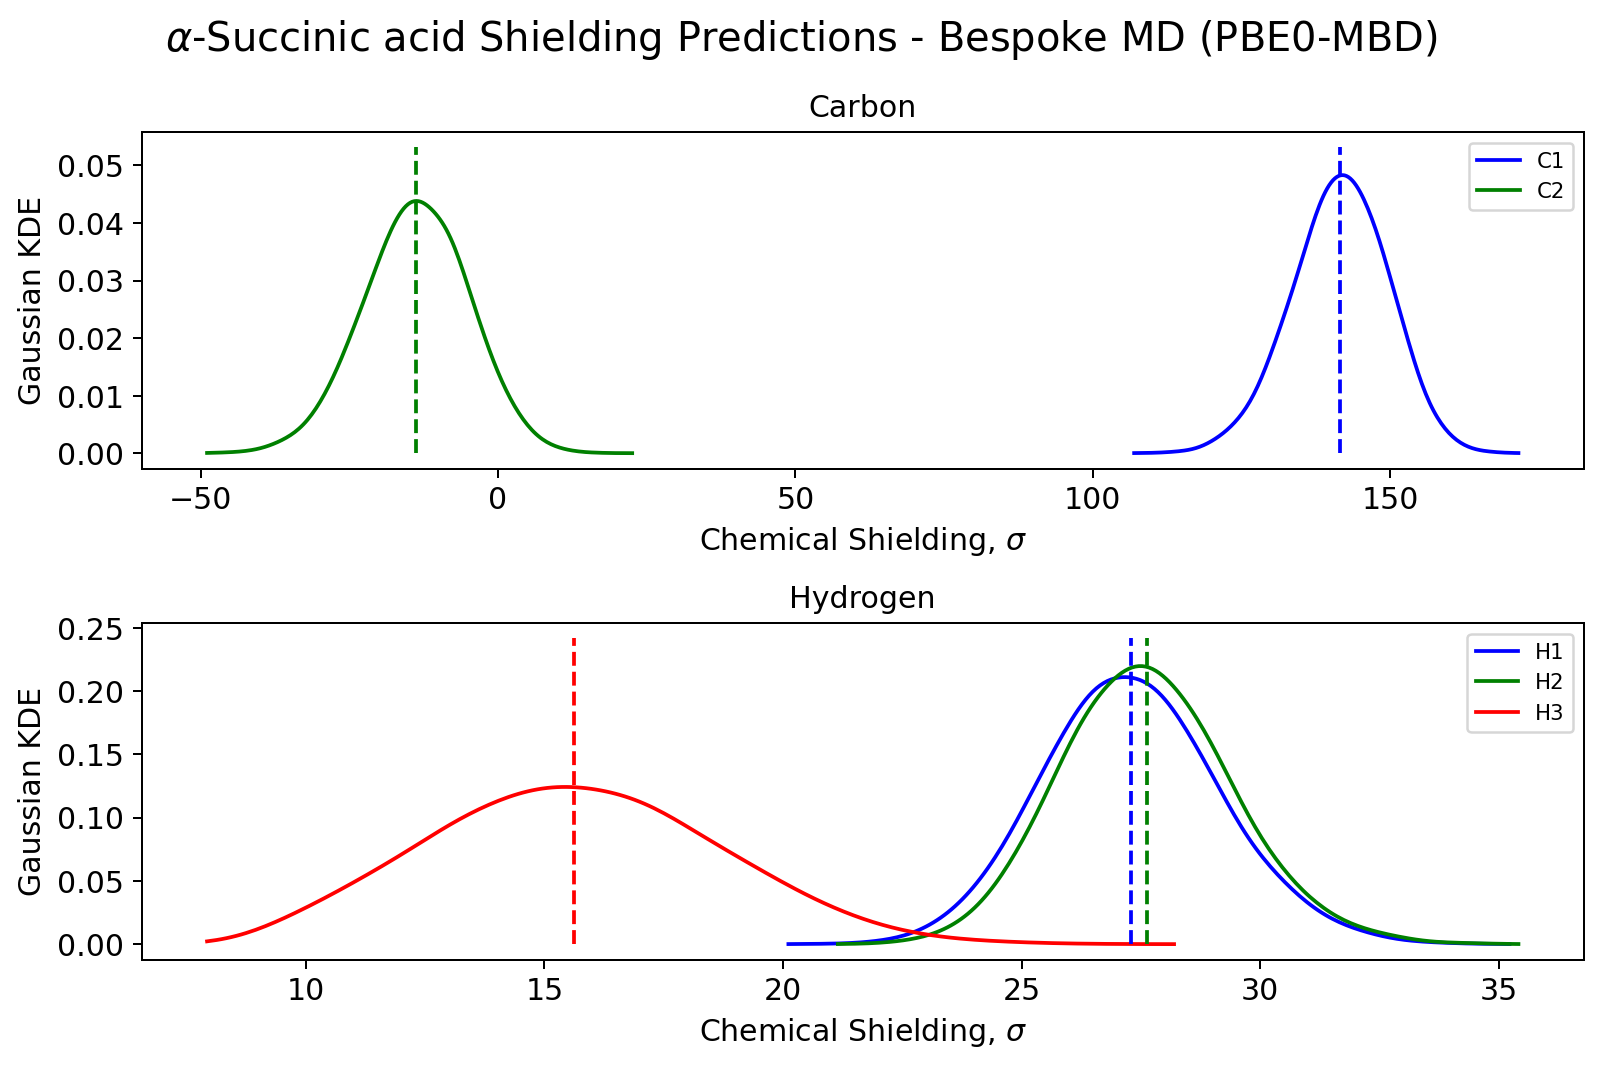

In [7]:
shieldings = plot_shieldings(suc_a_mbd, title=r'$\alpha$-Succinic acid Shielding Predictions - Bespoke MD (PBE0-MBD)')

In [8]:
#shieldings.savefig('edgar_inputs/shieldings/succinic_alpha/besmd_mbd.png',facecolor='white', dpi=200)

## Error estimation:

- For error estimation of the ML model:
  - The CSerr array has the rescaled standard deviation of each CS prediction
  - Find the standard deviation of the mean (i.e. the ML error of the mean chemical shift), for each chemical environment, using the following formula:
  $$
  \sqrt {\frac{\sum \limits_{i=1} ^N \sigma_i ^{2}}{N}}
  $$
  - Where sigma_i is the standard deviation (CSerr) of the CS prediction. N is the number of samples from the same chemical environment
  - I.e. the error of the mean chemical shift for a certain chemical environment (e.g. C3) is the sum of the squared errors (from CSerr), divided by the sample size, and then square rooted.
- For error estimation from sampling, just take the standard error of the mean
  - This is the mean of the shieldings, divided by the square root of the sample size
  $$
  \frac{\mu}{\sqrt{N}}
  $$
- The two sources of error should be summed to give the total error

## Converting shieldings to shifts:

Convert shieldings to shifts using the following formula:

$$
\delta_{iso} = \sigma_{ref} - Tr(\sigma)
$$

Where:
- $\delta_{iso}$ is the chemical shift
- $Tr(\sigma)$ is the chemical shielding of a certain nuclear environment
- $\sigma_{ref}$ is the reference chemical shielding (in the case of Edgar's paper, this is taken to be the average chemical shielding of all environments of a certain element)
  - Note that each environment has the same weighting, e.g. if there are two nuclei in environment A, and only one nucleus in environment B, the average chemical shielding will still be (sigma(A)+sigma(B))/2
 
Very important note: To convert experimental shifts to the shifts scale used in the paper, do not apply the same equation as that above (as experimental values are already chemical shifts). Instead, find the average chemical shift $\sigma_{ref}$ and subtract this from the experimental shift $\sigma_{exp}$, i.e. $Adjusted = \sigma_{exp} - \sigma_{ref}$

In [9]:
def calculate_shifts_and_errors(processed_shieldings, glycine=False, genshield=False):
    '''
    Find mean shielding, chemical shift, sampling error, ml error (if genshield==False), and total (summed) error by reading a csv or dataframe with processed data (including errors)
    If glycine is being analysed, the process is slightly different, so make sure the argument glycine = True
    If Matthias's general shielding model was used, make sure genshield=True
    '''
    
    # Read csv or dataframe
    if type(processed_shieldings)==str:
        df= pd.read_csv(processed_shieldings, index_col=0)
    elif isinstance(processed_shieldings, pd.DataFrame):
        df= processed_shieldings
    else:
        print('Input file not read.')
    
    shifts_and_errors = pd.DataFrame(columns=['Nucleus','Mean shielding','Chemical shifts', 'Sampling error', 'ML error', 'Total error'])
    mean_shield=[]; nuc=[]; sam_err=[]; ml_err=[]; tot_err=[]; car=[]; hyd=[]; nit=[]; oxy=[]; shifts=[]; nuclei=[]
    
    for header in df.columns:
        if len(header)<4:
            nuclei.append(header)
    if glycine==True:
        nuclei.append('H3')
    
    # Find mean shielding for each element
    for nucleus in nuclei:
        if glycine==True and nucleus=='H3':
            shield_data = list(df['H3_a'])
            shield_data.extend(df['H3_b'])
            shield_data.extend(df['H3_c'])
        else:
            shield_data=df[nucleus]
        if genshield==False:
            if glycine==True and nucleus=='H3':
                err_data = list(df['H3_aerr'])
                err_data.extend(df['H3_berr'])
                err_data.extend(df['H3_cerr'])
            else:
                err_data=df[nucleus+'err']
        
        mean=np.mean(shield_data)
        
        if nucleus[0]=='C':
            car.append(mean)
        if nucleus[0]=='H':
            hyd.append(mean)
        if nucleus[0]=='N':
            nit.append(mean)
        if nucleus[0]=='O':
            oxy.append(mean)
    
    for nucleus in nuclei:
        if glycine==True and nucleus=='H3':
            shield_data = list(df['H3_a'])
            shield_data.extend(df['H3_b'])
            shield_data.extend(df['H3_c'])
        else:
            shield_data=df[nucleus]
        if genshield==False:
            if glycine==True and nucleus=='H3':
                err_data = list(df['H3_aerr'])
                err_data.extend(df['H3_berr'])
                err_data.extend(df['H3_cerr'])
            else:
                err_data=df[nucleus+'err']
        
        # Get sample size N (number of shielding/error values)
        N= len(shield_data)
        nuc.append(nucleus)
        
        # Get mean shielding for nuclear environment
        mean=np.mean(shield_data)
        mean_shield.append(mean)
        
        # Get error from thermodynamic sampling
        sample_error = np.std(shield_data)/np.sqrt(N)
        sam_err.append(sample_error)
        
        if genshield==False:
            # Get error from the ML method
            ml_error = np.sqrt(np.sum([i**2 for i in err_data])/N)
            ml_err.append(ml_error)
            
            # Combine errors to give total error
            total_error = sample_error + ml_error
            tot_err.append(total_error)
        
        elif genshield==True:
            # Total error is just sample error in this case
            total_error = sample_error
            tot_err.append(total_error)
        
        # Convert shielding to shift
        if nucleus[0]=='C':
            shift = np.mean(car)- mean
        if nucleus[0]=='H':
            shift = np.mean(hyd)- mean
        if nucleus[0]=='N':
            shift = np.mean(nit)- mean
        if nucleus[0]=='O':
            shift = np.mean(oxy)- mean
        
        shifts.append(shift)
    
    # Add data to new dataframe
    shifts_and_errors['Nucleus']=nuc
    shifts_and_errors['Mean shielding']=mean_shield
    shifts_and_errors['Sampling error']=sam_err
    shifts_and_errors['Total error']=tot_err
    shifts_and_errors['Chemical shifts']=shifts
    if genshield==False:
        shifts_and_errors['ML error']=ml_err
    
    # Save dataframe as 'shifts_w_errors.csv' -- Uncomment below if you would this functionality
    #shifts_and_errors.to_csv('shifts_w_errors.csv')
    #print('Results (dataframe) returned and saved to file called shifts_w_errors.csv')
    
    return shifts_and_errors

In [10]:
#calculate shifts with errors
gly_g_mbd_clean= calculate_shifts_and_errors(gly_g_mbd, glycine=True)
gly_g_ts_clean= calculate_shifts_and_errors(gly_g_ts, glycine=True)
gly_g_gen_clean= calculate_shifts_and_errors(gly_g_gen, glycine=True)
gly_g_gen_mbd_clean= calculate_shifts_and_errors(gly_g_gen_mbd, glycine=True)
gly_a_mbd_clean= calculate_shifts_and_errors(gly_a_mbd, glycine=True)
gly_a_ts_clean= calculate_shifts_and_errors(gly_a_ts, glycine=True)
gly_a_gen_clean= calculate_shifts_and_errors(gly_a_gen, glycine=True)
gly_a_gen_mbd_clean= calculate_shifts_and_errors(gly_a_gen_mbd, glycine=True)
gly_b_mbd_clean= calculate_shifts_and_errors(gly_b_mbd, glycine=True)
gly_b_ts_clean= calculate_shifts_and_errors(gly_b_ts, glycine=True)
gly_b_gen_clean= calculate_shifts_and_errors(gly_b_gen, glycine=True)
gly_b_gen_mbd_clean= calculate_shifts_and_errors(gly_b_gen_mbd, glycine=True)
suc_a_mbd_clean= calculate_shifts_and_errors(suc_a_mbd)
suc_a_ts_clean= calculate_shifts_and_errors(suc_a_ts)
suc_a_gen_clean= calculate_shifts_and_errors(suc_a_gen)
suc_a_gen_mbd_clean= calculate_shifts_and_errors(suc_a_gen_mbd)
suc_b_mbd_clean= calculate_shifts_and_errors(suc_b_mbd)
suc_b_ts_clean= calculate_shifts_and_errors(suc_b_ts)
suc_b_gen_clean= calculate_shifts_and_errors(suc_b_gen)
suc_b_gen_mbd_clean= calculate_shifts_and_errors(suc_b_gen_mbd)
ben_I_mbd_clean= calculate_shifts_and_errors(ben_I_mbd)
ben_I_ts_clean= calculate_shifts_and_errors(ben_I_ts)
ben_I_gen_clean= calculate_shifts_and_errors(ben_I_gen)
ben_I_gen_mbd_clean= calculate_shifts_and_errors(ben_I_gen_mbd)
ben_II_mbd_clean= calculate_shifts_and_errors(ben_II_mbd)
ben_II_ts_clean= calculate_shifts_and_errors(ben_II_ts)
ben_II_gen_clean= calculate_shifts_and_errors(ben_II_gen)
ben_II_gen_mbd_clean= calculate_shifts_and_errors(ben_II_gen_mbd)

In [11]:
suc_b_gen_mbd_clean

,Nucleus,Mean shielding,Chemical shifts,Sampling error,ML error,Total error
0,C1,141.746700,-77.632098,0.042352,0.758043,0.800395
1,C2,-13.517496,77.632098,0.047200,0.744470,0.791670
2,H1,27.610456,-3.429110,0.009885,0.141186,0.151071
3,H2,27.631124,-3.449777,0.009734,0.157653,0.167387
4,H3,17.302460,6.878887,0.015906,0.266867,0.282773


In [12]:
#Experimental shifts
exp_succinic_a = {'C1': 29, 'C2': 180.8}
exp_succinic_b = {'C1': 29, 'C2': 180.8}
exp_glycine_a = {'C1': 176.5, 'C2': 43.4, 'H1': 4.2, 'H2': 3.1, 'H3': 8.4}
exp_glycine_b = {'C1': 175.5, 'C2': 43.2, 'H1': 2.5, 'H2': 2.2, 'H3': 7.4}
exp_glycine_g = {'C1': 174.5, 'C2': 42.4, 'H1': 3.3, 'H2': 3.1, 'H3': 8.8}

#Experimental shifts adjusted -- These used the formula shift - shift(ref) as they were already chemical shifts.
exp_adj_succinic_a = {'C1': -75.9, 'C2': 75.9}
exp_adj_succinic_b = {'C1': -75.9, 'C2': 75.9}
exp_adj_glycine_a = {'C1': 66.55, 'C2': -66.55, 'H1': -1.03, 'H2': -2.13, 'H3': 3.17}
exp_adj_glycine_b = {'C1': 66.15, 'C2': -66.15, 'H1': -1.53, 'H2': -1.83, 'H3': 3.36}
exp_adj_glycine_g = {'C1': 66.05, 'C2': -66.05, 'H1': -1.77, 'H2': -1.97, 'H3': 3.73}

#Geometry optimised shieldings (from Edgar's SI)
geop_shield_benzene_I= {'H1': 25.39, 'H1err': 0.03, 'H2': 24.23, 'H2err': 0.03, 'H3': 24.08, 'H3err': 0.03, 'C1': 38.46, 'C1err': 0.47, 'C2': 41.89, 'C2err': 0.49, 'C3': 42.57, 'C3err': 0.34}
geop_shield_benzene_II= {'H1': 25.79, 'H1err': 0.08, 'H2': 24.24, 'H2err': 0.09, 'H3': 23.76, 'H3err': 0.12, 'C1': 39.80, 'C1err': 0.55, 'C2': 42.10, 'C2err': 0.81, 'C3': 42.10, 'C3err': 0.82}
geop_shield_succinic_a= {'H1': 27.88, 'H1err': 0.04, 'H2': 28.55, 'H2err': 0.05, 'H3': 16.20, 'H3err': 0.05, 'C1': 146.65, 'C1err': 0.29, 'C2': -11.18, 'C2err': 0.26}
geop_shield_succinic_b= {'H1': 27.92, 'H1err': 0.03, 'H2': 28.46, 'H2err': 0.04, 'H3': 16.82, 'H3err': 0.04, 'C1': 146.01, 'C1err': 0.20, 'C2': -10.18, 'C2err': 0.20}
geop_shield_glycine_a= {'H1': 27.09, 'H1err': 0.04, 'H2': 27.76, 'H2err': 0.04, 'H3': 21.41, 'H3err': 0.02, 'C1': -2.64, 'C1err': 0.18, 'C2': 133.46, 'C2err': 0.19, 'N1': 199.84, 'N1err': 0.38}
geop_shield_glycine_b= {'H1': 26.65, 'H1err': 0.27, 'H2': 27.68, 'H2err': 0.28, 'H3': 21.86, 'H3err': 0.24, 'C1': -2.99, 'C1err': 0.55, 'C2': 133.20, 'C2err': 0.84, 'N1': 200.93, 'N1err': 1.50}
geop_shield_glycine_g= {'H1': 26.02, 'H1err': 0.03, 'H2': 27.27, 'H2err': 0.03, 'H3': 21.66, 'H3err': 0.02, 'C1': -6.68, 'C1err': 0.10, 'C2': 131.46, 'C2err': 0.22, 'N1': 199.91, 'N1err': 0.34}

#Geometry optimised shifts 
geop_shift_benzene_I= {'H1': -0.82, 'H1err': 0.03, 'H2': 0.34, 'H2err': 0.03, 'H3': 0.49, 'H3err': 0.03, 'C1': 2.51, 'C1err': 0.47, 'C2': -0.91, 'C2err': 0.49, 'C3': -1.59, 'C3err': 0.34}
geop_shift_benzene_II= {'H1': -1.19, 'H1err': 0.08, 'H2': 0.36, 'H2err': 0.09, 'H3': 0.84, 'H3err': 0.12, 'C1': 1.53, 'C1err': 0.55, 'C2': -0.77, 'C2err': 0.81, 'C3': -0.77, 'C3err': 0.82}
geop_shift_succinic_a= {'H1': -3.67, 'H1err': 0.04, 'H2': -4.34, 'H2err': 0.05, 'H3': 8.01, 'H3err': 0.05, 'C1': -78.92, 'C1err': 0.29, 'C2': 78.92, 'C2err': 0.26}
geop_shift_succinic_b= {'H1': -3.52, 'H1err': 0.03, 'H2': -4.06, 'H2err': 0.04, 'H3': 7.58, 'H3err': 0.04, 'C1': -78.10, 'C1err': 0.20, 'C2': 78.10, 'C2err': 0.20}
geop_shift_glycine_a= {'H1': -1.67, 'H1err': 0.04, 'H2': -2.34, 'H2err': 0.04, 'H3': 4.01, 'H3err': 0.02, 'C1': 68.05, 'C1err': 0.18, 'C2': -68.05, 'C2err': 0.19}
geop_shift_glycine_b= {'H1': -1.25, 'H1err': 0.27, 'H2': -2.28, 'H2err': 0.28, 'H3': 3.54, 'H3err': 0.24, 'C1': 68.10, 'C1err': 0.55, 'C2': -68.10, 'C2err': 0.84}
geop_shift_glycine_g= {'H1': -1.04, 'H1err': 0.03, 'H2': -2.29, 'H2err': 0.03, 'H3': 3.32, 'H3err': 0.02, 'C1': 69.07, 'C1err': 0.10, 'C2': -69.07, 'C2err': 0.22}

In [13]:
def plot_shifts(besmd_mbd, besmd_ts, genmd, name):
    '''
    NOTES: 
    1. The following dataframes must be provided: 
    - Bespoke MD (PBE0+MBD) + Bespoke Shift
    - Bespoke MD (PBE+TS) + Bespoke Shift
    - General MD (PBE+TS) + Bespoke Shift 
    2. The name of the molecule, and polymorph type, must be passed.
    - Use the following format: glycine_g, succinic_a, benzene_I, etc.
    '''
    #Experimental shifts adjusted -- These used the formula shift - shift(ref) as they were already chemical shifts.
    exp_adj_succinic_a = {'C1': -75.9, 'C2': 75.9}
    exp_adj_succinic_b = {'C1': -75.9, 'C2': 75.9}
    exp_adj_glycine_a = {'C1': 66.55, 'C2': -66.55, 'H1': -1.03, 'H2': -2.13, 'H3': 3.17}
    exp_adj_glycine_b = {'C1': 66.15, 'C2': -66.15, 'H1': -1.53, 'H2': -1.83, 'H3': 3.36}
    exp_adj_glycine_g = {'C1': 66.05, 'C2': -66.05, 'H1': -1.77, 'H2': -1.97, 'H3': 3.73}
    
    #Geometry optimised shieldings (from Edgar's SI)
    geop_shield_benzene_I= {'H1': 25.39, 'H1err': 0.03, 'H2': 24.23, 'H2err': 0.03, 'H3': 24.08, 'H3err': 0.03, 'C1': 38.46, 'C1err': 0.47, 'C2': 41.89, 'C2err': 0.49, 'C3': 42.57, 'C3err': 0.34}
    geop_shield_benzene_II= {'H1': 25.79, 'H1err': 0.08, 'H2': 24.24, 'H2err': 0.09, 'H3': 23.76, 'H3err': 0.12, 'C1': 39.80, 'C1err': 0.55, 'C2': 42.10, 'C2err': 0.81, 'C3': 42.10, 'C3err': 0.82}
    geop_shield_succinic_a= {'H1': 27.88, 'H1err': 0.04, 'H2': 28.55, 'H2err': 0.05, 'H3': 16.20, 'H3err': 0.05, 'C1': 146.65, 'C1err': 0.29, 'C2': -11.18, 'C2err': 0.26}
    geop_shield_succinic_b= {'H1': 27.92, 'H1err': 0.03, 'H2': 28.46, 'H2err': 0.04, 'H3': 16.82, 'H3err': 0.04, 'C1': 146.01, 'C1err': 0.20, 'C2': -10.18, 'C2err': 0.20}
    geop_shield_glycine_a= {'H1': 27.09, 'H1err': 0.04, 'H2': 27.76, 'H2err': 0.04, 'H3': 21.41, 'H3err': 0.02, 'C1': -2.64, 'C1err': 0.18, 'C2': 133.46, 'C2err': 0.19, 'N1': 199.84, 'N1err': 0.38}
    geop_shield_glycine_b= {'H1': 26.65, 'H1err': 0.27, 'H2': 27.68, 'H2err': 0.28, 'H3': 21.86, 'H3err': 0.24, 'C1': -2.99, 'C1err': 0.55, 'C2': 133.20, 'C2err': 0.84, 'N1': 200.93, 'N1err': 1.50}
    geop_shield_glycine_g= {'H1': 26.02, 'H1err': 0.03, 'H2': 27.27, 'H2err': 0.03, 'H3': 21.66, 'H3err': 0.02, 'C1': -6.68, 'C1err': 0.10, 'C2': 131.46, 'C2err': 0.22, 'N1': 199.91, 'N1err': 0.34}

    #Geometry optimised shifts 
    geop_shift_benzene_I= {'H1': -0.82, 'H1err': 0.03, 'H2': 0.34, 'H2err': 0.03, 'H3': 0.49, 'H3err': 0.03, 'C1': 2.51, 'C1err': 0.47, 'C2': -0.91, 'C2err': 0.49, 'C3': -1.59, 'C3err': 0.34}
    geop_shift_benzene_II= {'H1': -1.19, 'H1err': 0.08, 'H2': 0.36, 'H2err': 0.09, 'H3': 0.84, 'H3err': 0.12, 'C1': 1.53, 'C1err': 0.55, 'C2': -0.77, 'C2err': 0.81, 'C3': -0.77, 'C3err': 0.82}
    geop_shift_succinic_a= {'H1': -3.67, 'H1err': 0.04, 'H2': -4.34, 'H2err': 0.05, 'H3': 8.01, 'H3err': 0.05, 'C1': -78.92, 'C1err': 0.29, 'C2': 78.92, 'C2err': 0.26}
    geop_shift_succinic_b= {'H1': -3.52, 'H1err': 0.03, 'H2': -4.06, 'H2err': 0.04, 'H3': 7.58, 'H3err': 0.04, 'C1': -78.10, 'C1err': 0.20, 'C2': 78.10, 'C2err': 0.20}
    geop_shift_glycine_a= {'H1': -1.67, 'H1err': 0.04, 'H2': -2.34, 'H2err': 0.04, 'H3': 4.01, 'H3err': 0.02, 'C1': 68.05, 'C1err': 0.18, 'C2': -68.05, 'C2err': 0.19}
    geop_shift_glycine_b= {'H1': -1.25, 'H1err': 0.27, 'H2': -2.28, 'H2err': 0.28, 'H3': 3.54, 'H3err': 0.24, 'C1': 68.10, 'C1err': 0.55, 'C2': -68.10, 'C2err': 0.84}
    geop_shift_glycine_g= {'H1': -1.04, 'H1err': 0.03, 'H2': -2.29, 'H2err': 0.03, 'H3': 3.32, 'H3err': 0.02, 'C1': 69.07, 'C1err': 0.10, 'C2': -69.07, 'C2err': 0.22}
    
    titles={'glycine_a':r'$\alpha$-Glycine','glycine_b':r'$\beta$-Glycine','glycine_g':r'$\gamma$-Glycine','succinic_a':r'$\alpha$-Succinic acid','succinic_b':r'$\beta$-Succinic acid','benzene_I':'Benzene I','benzene_II':'Benzene II'}
    
    geop_shift=eval('geop_shift_'+name)
    geop_shield=eval('geop_shield_'+name)
    
    if 'exp_adj_'+name in locals():
        exp_shift=eval('exp_adj_'+name)
    
    shifts, species = plt.subplots(2, 3, figsize=(10,6), dpi=180)
    labels=['Bespoke MD (PBE0-MBD)','Bespoke MD (PBE-TS)', 'General MD (PBE-TS)']
    j=0
    k=0
    for dataframe in [besmd_mbd, besmd_ts, genmd]:
        names = dataframe["Nucleus"]
        y = dataframe["Chemical shifts"]
        y_error = dataframe["Total error"]
        yn = dataframe["Mean shielding"]

        for i in range(len(names)):
            if 'exp_shift' in locals() and names[i] in exp_shift:
                s=-0.75
            else:
                s=-0.5
            if names[i][0]=='C' or names[i][0]=='N':
                pl1=0
                pl2=i
            elif names[i][0]=='H':
                pl1=1
                if name== 'succinic_a' or name== 'succinic_b':
                    pl2=i-2
                else:
                    pl2=i-3
            if names[i][0]=='C' or names[i][0]=='H':
                horizontal= geop_shift[names[i]]
                species[pl1,pl2].errorbar(s+k, y[i]-horizontal, yerr= y_error[i], xerr=None, fmt='o', capsize=6, label=labels[j])
                species[pl1,pl2].axes.xaxis.set_visible(False)
            elif names[i][0]=='N':
                horizontal= geop_shield[names[i]]
                species[pl1,pl2].errorbar(s+k, yn[i]-horizontal, yerr= y_error[i], xerr=None, fmt='o', capsize=6, label=labels[j])
                species[pl1,pl2].axes.xaxis.set_visible(False)
        j+=1
        k+=0.5
    
    names = besmd_mbd["Nucleus"]
    y = besmd_mbd["Chemical shifts"]
    y_error = besmd_mbd["Total error"]
    
    for i in range(len(names)):
        if names[i][0]=='C':
                pl1=0
                pl2=i
                ran=10
        elif names[i][0]=='H':
                pl1=1
                if name== 'succinic_a' or name== 'succinic_b':
                    pl2=i-2
                else:
                    pl2=i-3
                ran=2
        elif names[i][0]=='N':
                pl1=0
                pl2=i
                ran=15
        if names[i][0]=='C' or names[i][0]=='H':
                horizontal= geop_shift[names[i]]
        elif names[i][0]=='N':
                horizontal= geop_shield[names[i]]     
        if 'exp_shift' in locals() and names[i] in exp_shift:
                experimental = exp_shift[names[i]]
                species[pl1,pl2].plot(0.75, experimental-horizontal, 'ro', color='red', marker='x', markersize=9, label='Experimental')
        species[pl1,pl2].hlines(y=0, xmin=-1, xmax=1, label='Geometry optimised', color='black')
        species[pl1,pl2].legend(loc=1, prop={'size': 6})
        species[pl1,pl2].set(title= names[i], ylim=(0-ran, 0+ran), ylabel=r'$\delta_{iso}$ - $\delta_{iso}^{geop}$ (ppm)')
        for item in ([species[pl1,pl2].title, species[pl1,pl2].xaxis.label, species[pl1,pl2].yaxis.label] +
            species[pl1,pl2].get_xticklabels() + species[pl1,pl2].get_yticklabels()):
                item.set_fontsize(12)
    
    if name=='succinic_a' or name=='succinic_b':
        shifts.delaxes(species[0,2])
    
    shifts.suptitle(titles[name]+ ' Chemical Shift Predictions using Various Methodologies')
    shifts.tight_layout(pad=1.5, w_pad=1.5)
    return shifts

/tmp/ipykernel_2483361/2660304357.py:105: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  species[pl1,pl2].plot(0.75, experimental-horizontal, 'ro', color='red', marker='x', markersize=9, label='Experimental')
/tmp/ipykernel_2483361/2660304357.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  species[pl1,pl2].plot(0.75, experimental-horizontal, 'ro', color='red', marker='x', markersize=9, label='Experimental')


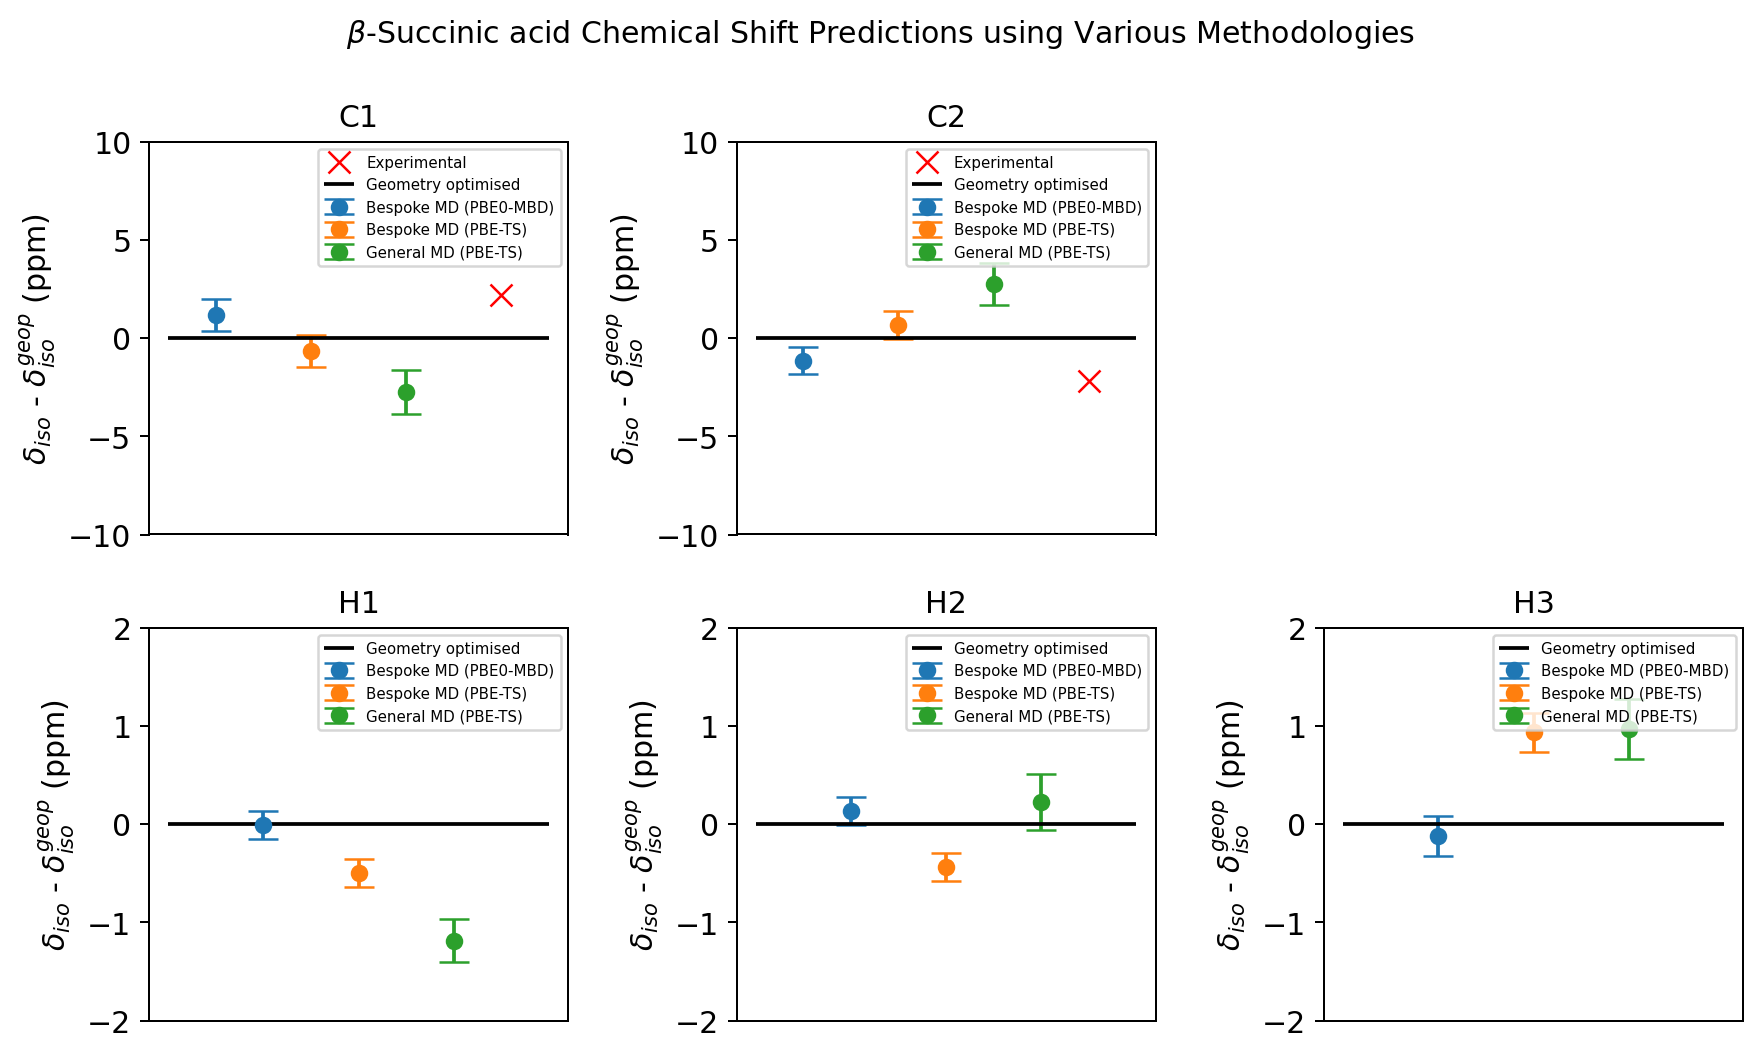

In [14]:
shifts=plot_shifts(besmd_mbd=suc_b_mbd_clean, besmd_ts=suc_b_ts_clean, genmd=suc_b_gen_clean, name="succinic_b")

In [15]:
#shifts.savefig('edgar_inputs/shifts/succinic_beta.png', facecolor='white', dpi=200)

# Make nicer plots
You should use these plots instead

In [16]:
def plot_shieldings_nice(df, title):
    #plot density distribution of shieldings from a dataframe (dataframe must have shielding columns without error columns)
    if 'N1' in df.columns:
        rows=3
        fig, ax = plt.subplots(nrows=rows, figsize=(9,9), dpi=180)
    else:
        rows=2
        fig, ax = plt.subplots(nrows=rows, figsize=(9,6), dpi=180)
    colours=['blue', 'green','red', 'black', 'orange', 'purple', 'brown']
    lc = 0; lh = 0; ln = 0
    maxes_c=[];maxes_h=[];maxes_n=[]
    
    ax[0].set(title= 'Carbon', xlabel= r'Chemical Shielding, $\sigma$ (ppm)', ylabel='Gaussian KDE')
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
            ax[0].get_xticklabels() + ax[0].get_yticklabels()):
            item.set_fontsize(12)
    
    ax[1].set(title= 'Hydrogen', xlabel= r'Chemical Shielding, $\sigma$ (ppm)', ylabel='Gaussian KDE')
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
            ax[1].get_xticklabels() + ax[1].get_yticklabels()):
            item.set_fontsize(12)
    
    if 'N1' in df.columns:
        ax[2].set(title= 'Nitrogen', xlabel= r'Chemical Shielding, $\sigma$ (ppm)', ylabel='Gaussian KDE')
        for item in ([ax[2].title, ax[2].xaxis.label, ax[2].yaxis.label] +
                ax[2].get_xticklabels() + ax[2].get_yticklabels()):
                item.set_fontsize(12)
    
    for i in df.columns:
        #get appropriate x-values
        xs= np.linspace(df.min()[i],df.max()[i],200)
        
        #estimate density from relevant chemical shielding array in dataframe
        normalize = gaussian_kde(df[i])
        normalize.covariance_factor = lambda : .25
        normalize._compute_covariance()
        
        #plot shieldings
        if i[0]=='C' and len(i)<5:
            ax[0].plot(xs, normalize(xs), color=colours[lc], label=str(i))
            maxes_c.append(max(normalize(xs)))
            lc += 1
            ax[0].legend(loc=1, prop={'size': 8.5})
            
        if i[0]=='H'and len(i)<5:
            ax[1].plot(xs, normalize(xs), color=colours[lh], label=str(i))
            maxes_h.append(max(normalize(xs)))
            lh += 1
            ax[1].legend(loc=1, prop={'size': 8.5})
        if i[0]=='N'and len(i)<5:
            ax[2].plot(xs, normalize(xs), color=colours[ln], label=str(i))
            maxes_n.append(max(normalize(xs)))
            ln += 1
            ax[2].legend(loc=1, prop={'size': 8.5})
    
    lc = 0; lh = 0; ln = 0
    for i in df.columns:
        if i[0]=='C' and len(i)<5:
            ax[0].vlines(np.mean(df[i]), ymin= 0, ymax=(max(maxes_c)+(0.10*max(maxes_c))), linestyles="dashed", color=colours[lc], label=str(i)+' mean')
            if i=='C2':
                ax[0].vlines(np.mean(df[i])+geop_shieldings_adjusted[i], ymin= 0, ymax=(max(maxes_c)+(0.10*max(maxes_c))), linestyles="dashed", color='black', label=' Geop')
            else:
                ax[0].vlines(np.mean(df[i])+geop_shieldings_adjusted[i], ymin= 0, ymax=(max(maxes_c)+(0.10*max(maxes_c))), linestyles="dashed", color='black')
            lc += 1
            ax[0].legend(loc=1, prop={'size': 8.5})
        if i[0]=='H'and len(i)<5:
            ax[1].vlines(np.mean(df[i]), ymin= 0, ymax=(max(maxes_h)+(0.10*max(maxes_h))), linestyles="dashed", color=colours[lh], label=str(i)+' mean')
            if i=='H3':
                ax[1].vlines(np.mean(df[i])+geop_shieldings_adjusted[i], ymin= 0, ymax=(max(maxes_h)+(0.10*max(maxes_h))), linestyles="dashed", color='black', label='Geop')
            else:
                ax[1].vlines(np.mean(df[i])+geop_shieldings_adjusted[i], ymin= 0, ymax=(max(maxes_h)+(0.10*max(maxes_h))), linestyles="dashed", color='black')
            lh += 1
            ax[1].legend(loc=1, prop={'size': 8.5})
        if i[0]=='N'and len(i)<5:
            ax[2].vlines(np.mean(df[i]), ymin= 0, ymax=(max(maxes_n)+(0.10*max(maxes_n))), linestyles="dashed", color=colours[ln])
            ln += 1
    
    fig.suptitle(title, size=16)
    #fig.delaxes(ax[1])
    fig.tight_layout()
    return fig

In [17]:
geop_shieldings_adjusted={'C1':1.15, 'C2':-1.15, 'H1':-0.01, 'H2':0.13, 'H3':-0.12}

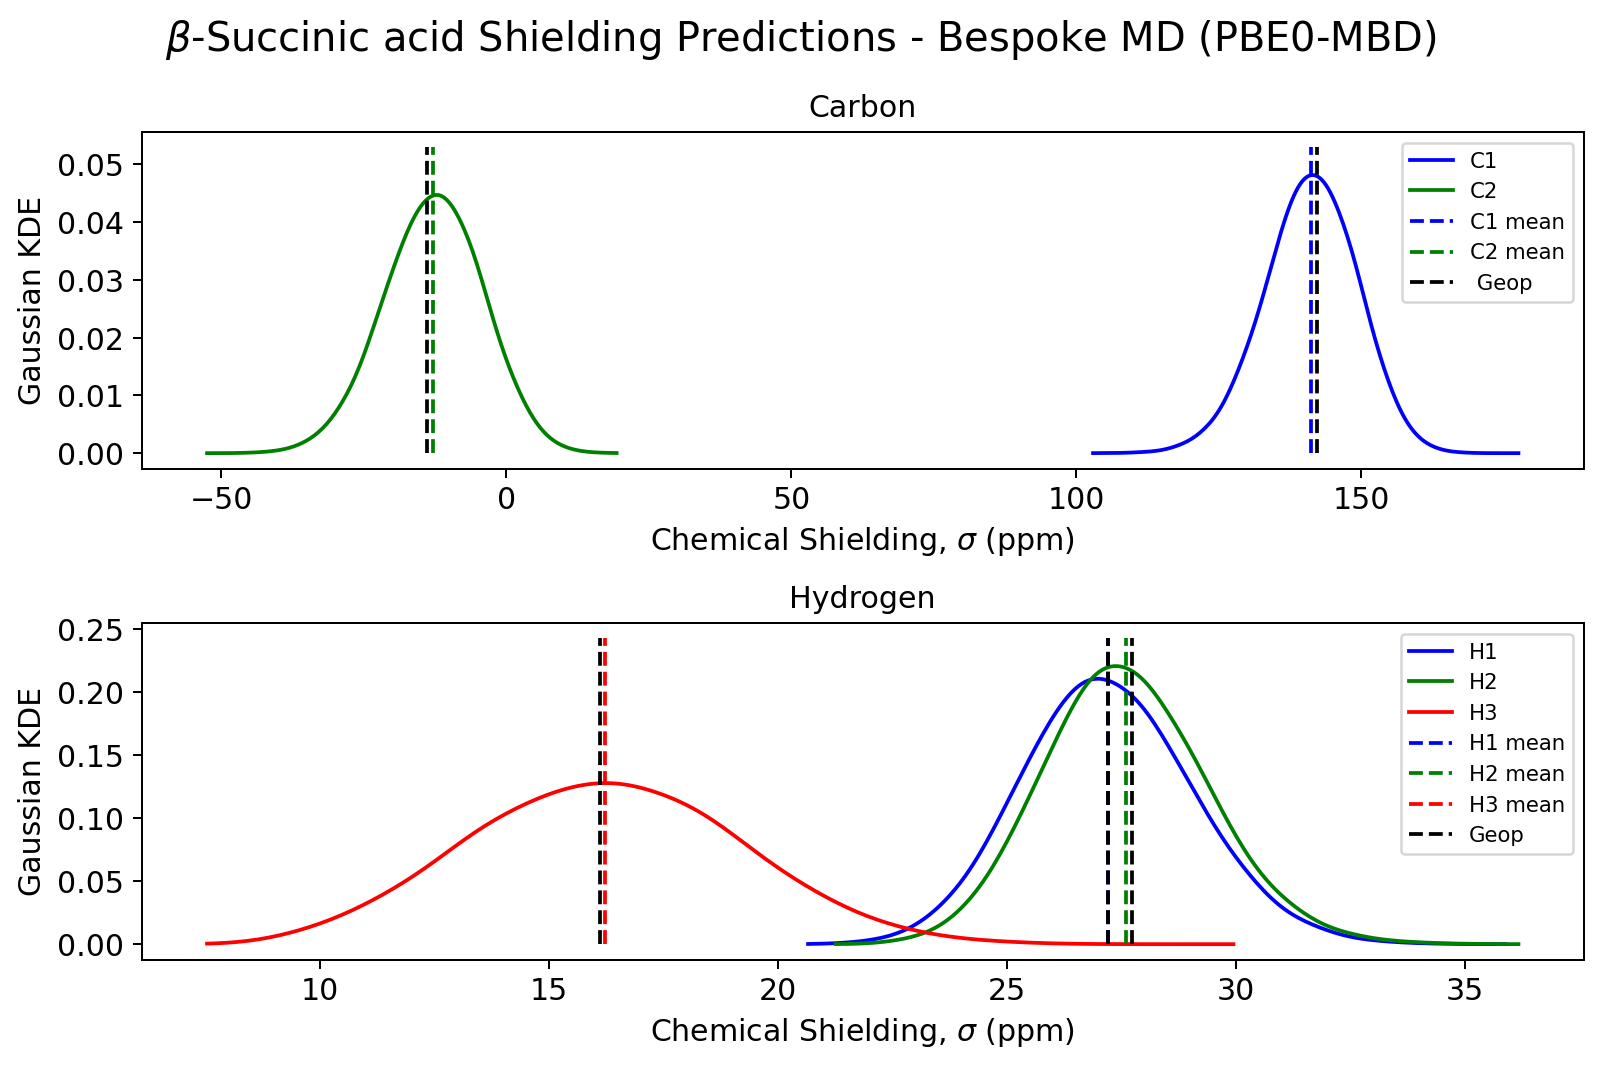

In [18]:
shieldings_sub_b_pres = plot_shieldings_nice(suc_b_mbd, title=r'$\beta$-Succinic acid Shielding Predictions - Bespoke MD (PBE0-MBD)')

In [19]:
def plot_shifts_nice(besmd_mbd, besmd_ts, genmd_ts, genmd_mbd, name):
    '''
    NOTES: 
    1. The following dataframes must be provided: 
    - Bespoke MD (PBE0+MBD) + Bespoke Shift
    - Bespoke MD (PBE+TS) + Bespoke Shift
    - General MD (PBE+TS) + Bespoke Shift 
    2. The name of the molecule, and polymorph type, must be passed.
    - Use the following format: glycine_g, succinic_a, benzene_I, etc.
    '''
    #Experimental shifts adjusted -- These used the formula shift - shift(ref) as they were already chemical shifts.
    exp_adj_succinic_a = {'C1': -75.9, 'C2': 75.9}
    exp_adj_succinic_b = {'C1': -75.9, 'C2': 75.9}
    exp_adj_glycine_a = {'C1': 66.55, 'C2': -66.55, 'H1': -1.03, 'H2': -2.13, 'H3': 3.17}
    exp_adj_glycine_b = {'C1': 66.15, 'C2': -66.15, 'H1': -1.53, 'H2': -1.83, 'H3': 3.36}
    exp_adj_glycine_g = {'C1': 66.05, 'C2': -66.05, 'H1': -1.77, 'H2': -1.97, 'H3': 3.73}
    
    #Geometry optimised shieldings (from Edgar's SI)
    geop_shield_benzene_I= {'H1': 25.39, 'H1err': 0.03, 'H2': 24.23, 'H2err': 0.03, 'H3': 24.08, 'H3err': 0.03, 'C1': 38.46, 'C1err': 0.47, 'C2': 41.89, 'C2err': 0.49, 'C3': 42.57, 'C3err': 0.34}
    geop_shield_benzene_II= {'H1': 25.79, 'H1err': 0.08, 'H2': 24.24, 'H2err': 0.09, 'H3': 23.76, 'H3err': 0.12, 'C1': 39.80, 'C1err': 0.55, 'C2': 42.10, 'C2err': 0.81, 'C3': 42.10, 'C3err': 0.82}
    geop_shield_succinic_a= {'H1': 27.88, 'H1err': 0.04, 'H2': 28.55, 'H2err': 0.05, 'H3': 16.20, 'H3err': 0.05, 'C1': 146.65, 'C1err': 0.29, 'C2': -11.18, 'C2err': 0.26}
    geop_shield_succinic_b= {'H1': 27.92, 'H1err': 0.03, 'H2': 28.46, 'H2err': 0.04, 'H3': 16.82, 'H3err': 0.04, 'C1': 146.01, 'C1err': 0.20, 'C2': -10.18, 'C2err': 0.20}
    geop_shield_glycine_a= {'H1': 27.09, 'H1err': 0.04, 'H2': 27.76, 'H2err': 0.04, 'H3': 21.41, 'H3err': 0.02, 'C1': -2.64, 'C1err': 0.18, 'C2': 133.46, 'C2err': 0.19, 'N1': 199.84, 'N1err': 0.38}
    geop_shield_glycine_b= {'H1': 26.65, 'H1err': 0.27, 'H2': 27.68, 'H2err': 0.28, 'H3': 21.86, 'H3err': 0.24, 'C1': -2.99, 'C1err': 0.55, 'C2': 133.20, 'C2err': 0.84, 'N1': 200.93, 'N1err': 1.50}
    geop_shield_glycine_g= {'H1': 26.02, 'H1err': 0.03, 'H2': 27.27, 'H2err': 0.03, 'H3': 21.66, 'H3err': 0.02, 'C1': -6.68, 'C1err': 0.10, 'C2': 131.46, 'C2err': 0.22, 'N1': 199.91, 'N1err': 0.34}

    #Geometry optimised shifts 
    geop_shift_benzene_I= {'H1': -0.82, 'H1err': 0.03, 'H2': 0.34, 'H2err': 0.03, 'H3': 0.49, 'H3err': 0.03, 'C1': 2.51, 'C1err': 0.47, 'C2': -0.91, 'C2err': 0.49, 'C3': -1.59, 'C3err': 0.34}
    geop_shift_benzene_II= {'H1': -1.19, 'H1err': 0.08, 'H2': 0.36, 'H2err': 0.09, 'H3': 0.84, 'H3err': 0.12, 'C1': 1.53, 'C1err': 0.55, 'C2': -0.77, 'C2err': 0.81, 'C3': -0.77, 'C3err': 0.82}
    geop_shift_succinic_a= {'H1': -3.67, 'H1err': 0.04, 'H2': -4.34, 'H2err': 0.05, 'H3': 8.01, 'H3err': 0.05, 'C1': -78.92, 'C1err': 0.29, 'C2': 78.92, 'C2err': 0.26}
    geop_shift_succinic_b= {'H1': -3.52, 'H1err': 0.03, 'H2': -4.06, 'H2err': 0.04, 'H3': 7.58, 'H3err': 0.04, 'C1': -78.10, 'C1err': 0.20, 'C2': 78.10, 'C2err': 0.20}
    geop_shift_glycine_a= {'H1': -1.67, 'H1err': 0.04, 'H2': -2.34, 'H2err': 0.04, 'H3': 4.01, 'H3err': 0.02, 'C1': 68.05, 'C1err': 0.18, 'C2': -68.05, 'C2err': 0.19}
    geop_shift_glycine_b= {'H1': -1.25, 'H1err': 0.27, 'H2': -2.28, 'H2err': 0.28, 'H3': 3.54, 'H3err': 0.24, 'C1': 68.10, 'C1err': 0.55, 'C2': -68.10, 'C2err': 0.84}
    geop_shift_glycine_g= {'H1': -1.04, 'H1err': 0.03, 'H2': -2.29, 'H2err': 0.03, 'H3': 3.32, 'H3err': 0.02, 'C1': 69.07, 'C1err': 0.10, 'C2': -69.07, 'C2err': 0.22}
    
    titles={'glycine_a':r'$\alpha$-Glycine','glycine_b':r'$\beta$-Glycine','glycine_g':r'$\gamma$-Glycine','succinic_a':r'$\alpha$-Succinic acid','succinic_b':r'$\beta$-Succinic acid','benzene_I':'Benzene I','benzene_II':'Benzene II'}
    
    geop_shift=eval('geop_shift_'+name)
    geop_shield=eval('geop_shield_'+name)
    
    if 'exp_adj_'+name in locals():
        exp_shift=eval('exp_adj_'+name)
    
    shifts, species = plt.subplots(2, 3, figsize=(10,6), dpi=200)
    labels=['Bespoke MD (PBE0-MBD)','Bespoke MD (PBE-TS)', 'General MD (PBE-TS)', 'General MD (PBE0-MBD)']
    j=0
    k=0
    for dataframe in [besmd_mbd, besmd_ts, genmd_ts, genmd_mbd]:
        names = dataframe["Nucleus"]
        y = dataframe["Chemical shifts"]
        y_error = dataframe["Sampling error"]
        yn = dataframe["Mean shielding"]

        for i in range(len(names)):
            s=-0.8
            if names[i][0]=='C' or names[i][0]=='N':
                pl1=0
                pl2=i
            elif names[i][0]=='H':
                pl1=1
                if name== 'succinic_a' or name== 'succinic_b':
                    pl2=i-2
                else:
                    pl2=i-3
            if names[i][0]=='C' or names[i][0]=='H':
                #horizontal= geop_shift[names[i]]
                species[pl1,pl2].errorbar(s+k, y[i], yerr= y_error[i], xerr=None, fmt='o', capsize=6, label=labels[j])
                species[pl1,pl2].axes.xaxis.set_visible(False)
            elif names[i][0]=='N':
                #horizontal= geop_shield[names[i]]
                #print(s+k)
                species[pl1,pl2].errorbar(s+k, yn[i], yerr= y_error[i], xerr=None, fmt='o', capsize=6, label=labels[j])
                species[pl1,pl2].axes.xaxis.set_visible(False)
        j+=1
        k+=0.4
    
    names = besmd_mbd["Nucleus"]
    y = besmd_mbd["Chemical shifts"]
    y_error = besmd_mbd["Total error"]
    
    for i in range(len(names)):
        if names[i][0]=='C':
                pl1=0
                pl2=i
                ran=0.75
        elif names[i][0]=='H':
                pl1=1
                if name== 'succinic_a' or name== 'succinic_b':
                    pl2=i-2
                else:
                    pl2=i-3
                ran=0.75
        elif names[i][0]=='N':
                pl1=0
                pl2=i
                ran=0.75
        if names[i][0]=='C' or names[i][0]=='H':
                geop= geop_shift[names[i]]
                geop_err= geop_shift[names[i]+'err']
        elif names[i][0]=='N':
                geop= geop_shield[names[i]]
                geop_err=geop_shield[names[i]+'err']
        if 'exp_shift' in locals() and names[i] in exp_shift:
                experimental = exp_shift[names[i]]
                #species[pl1,pl2].plot(0.75, experimental, 'ro', color='red', marker='x', markersize=9, label='Experimental')
                species[pl1,pl2].hlines(y=experimental, xmin=-1, xmax=1, label='Experimental', color='red')
        species[pl1,pl2].errorbar(s+k, geop, yerr= geop_err, xerr=None, fmt='o', capsize=6, label='Geometry optimised', color='black')
        species[pl1,pl2].legend(loc=1, prop={'size': 6})
        #species[pl1,pl2].set(title= names[i], ylim=(0-ran, 0+ran), ylabel=r'$\delta_{iso}$ - $\delta_{iso}^{geop}$ (ppm)')
        species[pl1,pl2].set(title= names[i], ymargin=ran, ylabel=r'$\delta_{iso}}$ (ppm)', xlim=(-1,1))
        for item in ([species[pl1,pl2].title, species[pl1,pl2].xaxis.label, species[pl1,pl2].yaxis.label] +
            species[pl1,pl2].get_xticklabels() + species[pl1,pl2].get_yticklabels()):
                item.set_fontsize(12)
        #if not handles:
            #handles = species[pl1,pl2]
    
    if name=='succinic_a' or name=='succinic_b':
        shifts.delaxes(species[0,2])
    
    #shifts.legend(handles, 
    #              ['Experimental', 'Bespoke MD (PBE0-MBD)','Bespoke MD (PBE-TS)', 
    #               'General MD (PBE-TS)', 'General MD (PBE0-MBD)'], bbox_to_anchor=(2, 0),loc = 'lower right')
    shifts.suptitle(titles[name]+ ' Chemical Shift Predictions using Various Methodologies')
    shifts.tight_layout(pad=1.5, w_pad=1.5)
    return shifts

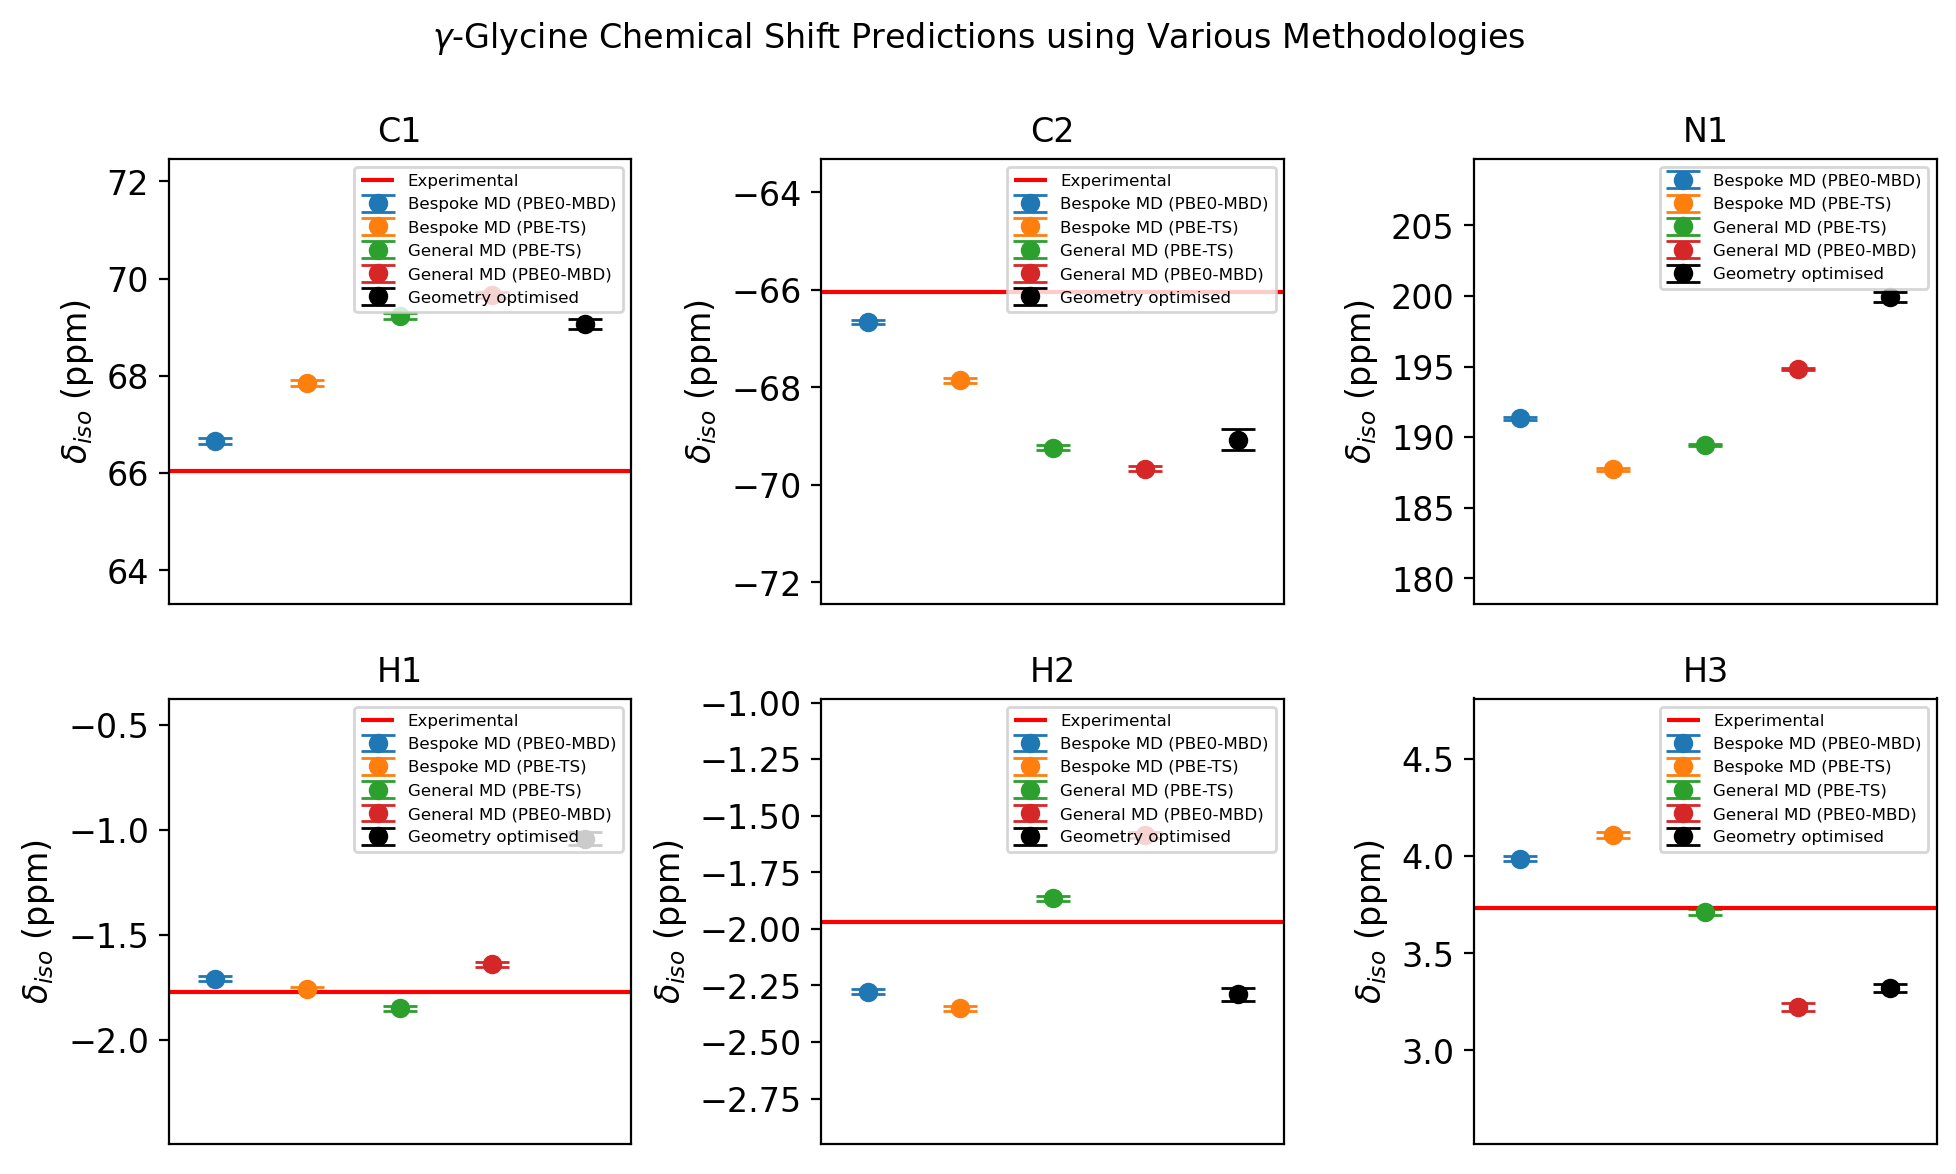

In [20]:
shifts=plot_shifts_nice(besmd_mbd=gly_g_mbd_clean, besmd_ts=gly_g_ts_clean, genmd_ts=gly_g_gen_clean, 
                        genmd_mbd=gly_g_gen_mbd_clean, name="glycine_g")

In [21]:
#shifts.savefig('gen_pbe0/shifts/glycine_gamma.png', facecolor='white')

In [22]:
gly_g_gen_mbd_clean

,Nucleus,Mean shielding,Chemical shifts,Sampling error,ML error,Total error
0,C1,-9.921532,69.663620,0.054532,2.106995,2.161527
1,C2,129.405707,-69.663620,0.044031,1.728198,1.772230
2,N1,194.833421,0.000000,0.075066,2.454821,2.529887
3,H1,26.138186,-1.638790,0.012036,0.363495,0.375531
4,H2,26.084551,-1.585155,0.012156,0.302794,0.314951
5,H3,21.275451,3.223945,0.018642,0.463867,0.482509
